# import modules

In [1]:
import numpy as np
import random
from scipy.stats import truncnorm
from scipy.special import softmax
from collections import Counter
import os
import seaborn as sns
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from sklearn.metrics import accuracy_score, log_loss

# Crea utenti e salva file

Le caratteristiche dell'utente per determinare se un immagine è vera o falsa sono: 
*   Pensiero Critico: float [0,1]
*   Conscenza del topic: float [0,1]. 
*   Virality preference: float [0,1]. Scale the image virality (which is an int 
)
*   Topic Preferences:  array with n-dimension n = number of topics    
*   Fakeness: average the  



In [2]:
def create_users(num_users, num_topic):
  topic_pref     = np.random.uniform(low =-1,   high=1,   size=(num_users, num_topic))
  fakeness_pref  = np.random.uniform(low = 0,   high=1,   size=(num_users))
  virality_pref  = np.random.uniform(low =-1,   high=1,   size=(num_users))
  cred_pref      = np.random.uniform(low = 0,   high=1,   size=(num_users))
  ricon_manip    = np.random.uniform(low = 0.8, high=1, size=(num_users))
  crit_think     = np.random.uniform(low = 0.8, high=1, size=(num_users))
  kt             = np.random.uniform(low = 0.8, high=1, size=(num_users, num_topic))
  #embedd        = np.random.uniform(low = 0, high=1, size=(num_users, 1000))
  #dict_user_pref= {user: {'embedding':embedd[user, :],'topic':topic_pref[user, :], 'fake':fakeness_pref[user], 'virality':virality_pref[user], 'credibility_user':cred_pref[user], 'rm': ricon_manip[user], 'crit_think': crit_think[user], 'kt': kt[user]} for user in range(num_users)}
  dict_user_pref = {user: {'topic':topic_pref[user, :], 'fake':fakeness_pref[user], 'virality':virality_pref[user], 'credibility_user':cred_pref[user], 'rm': ricon_manip[user], 'crit_think': crit_think[user], 'kt': kt[user]} for user in range(num_users)}
  return dict_user_pref#, embedd

In [3]:
#salvare file utente
dict_user = create_users(10, 4)

## Family specifc user

In [ ]:
def create_users_with_param(num_users, num_topic, fmin, fmax, virmin, virmax, manipmin, manipmax, ctmin, ctmax, ktmin, ktmax):
  topic_pref     = np.random.uniform(low =-1,        high=1,   size=(num_users, num_topic))
  fakeness_pref  = np.random.uniform(low = fmin,     high=fmax,   size=(num_users))
  virality_pref  = np.random.uniform(low =virmin,    high=virmax,   size=(num_users))
  cred_pref      = np.random.uniform(low = 0,        high= 1,   size=(num_users))
  ricon_manip    = np.random.uniform(low = manipmin, high=manipmax, size=(num_users))
  crit_think     = np.random.uniform(low = ctmin,    high=ctmax, size=(num_users))
  kt             = np.random.uniform(low = ktmin,    high=ktmax, size=(num_users, num_topic))
  #embedd        = np.random.uniform(low = 0, high=1, size=(num_users, 1000))
  #dict_user_pref= {user: {'embedding':embedd[user, :],'topic':topic_pref[user, :], 'fake':fakeness_pref[user], 'virality':virality_pref[user], 'credibility_user':cred_pref[user], 'rm': ricon_manip[user], 'crit_think': crit_think[user], 'kt': kt[user]} for user in range(num_users)}
  dict_user_pref = {user: {'topic':topic_pref[user, :], 'fake':fakeness_pref[user], 'virality':virality_pref[user], 'credibility_user':cred_pref[user], 'rm': ricon_manip[user], 'crit_think': crit_think[user], 'kt': kt[user]} for user in range(num_users)}
  return dict_user_pref#, embedd

In [ ]:
fam_low = create_users_with_param(num_users=500, num_topic=4, fmin=0.0, fmax=0.33, virmin=-1, virmax=1, manipmin=0.0, manipmax=0.33, ctmin=0.0, ctmax=0.33, ktmin=0.0, ktmax=0.33)
fam_med = create_users_with_param(num_users=500, num_topic=4, fmin=0.33, fmax=0.66, virmin=-1, virmax=1, manipmin=0.33, manipmax=0.66, ctmin=0.33, ctmax=0.66, ktmin=0.33, ktmax=0.66)
fam_hig = create_users_with_param(num_users=500, num_topic=4, fmin=0.66, fmax=1, virmin=-1, virmax=1    , manipmin=0.66, manipmax=1, ctmin=0.66, ctmax=1, ktmin=0.66, ktmax=1)


fam_lowCT_high_FK_low_rm = create_users_with_param(num_users=500, num_topic=4, fmin=0.66, fmax=1,    virmin=-1, virmax=1, manipmin=0.0, manipmax=0.33, ctmin=0.0,  ctmax=0.33, ktmin=0, ktmax=1)
fam_MED_CT_medFK_MED_RM  = create_users_with_param(num_users=500, num_topic=4, fmin=0.33, fmax=0.66, virmin=-1, virmax=1, manipmin=0.33,manipmax=0.66, ctmin=0.33, ctmax=0.66, ktmin=0, ktmax=1)
fam_higCT_lowFK_high_rm  = create_users_with_param(num_users=500, num_topic=4, fmin=0.0,  fmax=0.33, virmin=-1, virmax=1, manipmin=0.66, manipmax=1,   ctmin=0.66, ctmax= 1,   ktmin=0, ktmax=1)



# Carica dati immagini reali

In [4]:
df_imgs = pd.read_excel('C:\\Users\\ospite\\Documents\\user-simulation-regression\\data\\DEF_images_data.xlsx', index_col=0)

In [5]:
dict_tf = {"T" : 0, "F" : 1}
dict_auth = {"T" : 0, "F" : 1}
dict_topic = {"space" : 0, "politics" : 1, 'naturaldisaster': 2,'commons':3}
df_imgs['cred'] = np.random.choice([0, 0.5, 1], df_imgs.shape[0])
df_imgs['manip'] = np.random.choice([0, 0.5, 1], df_imgs.shape[0]) #np.random.random(df_imgs.shape[0])
df_imgs.replace({"authenticity": dict_auth,"t_f": dict_tf, 'topic': dict_topic, },inplace=True)

df_imgs.head(4)

,topic,t_f,authenticity,url,virality,interpret,NOT_ann_qualtrics_url,path_drive_not_annotated,id_qualtrics_not_annotated_img,annotated_name,annotated_qualtrics_name,start_id,middle_id,end_id,annotated_qualttrics link,ita_trad,EST,cred,manip
space_rover_sistem_TRUE.jpg,0,0,0,https://www.jpl.nasa.gov/news/twin-of-nasas-pe...,4.027092,"Updated with new features, including additiona...","<img src=""https://qfreeaccountssjc1.az1.qualtr...",/content/drive/MyDrive/Resized_images/space/sp...,IM_9B6a36NQaVHeL78,annoted_space_rover_sistem_TRUE.jpg,IM_3qLneJI5SNDf6tM,"<img src=""",https://qfreeaccountssjc1.az1.qualtrics.com/Co...,"""/>","<img src=""https://qfreeaccountssjc1.az1.qualtr...","Aggiornato con nuove funzionalità, tra cui sof...",INTERPRET,1.0,0.0
nasa_fake_mars_rover.jpg,0,1,0,https://edition.cnn.com/2016/07/15/health/mars...,3.040368,NASA’s Mars 2020 rover will explore the Red Pl...,"<img src=""https://qfreeaccountssjc1.az1.qualtr...",/content/drive/MyDrive/Resized_images/space/na...,IM_eMcmqjB7SmJAPhY,annoted_nasa_fake_mars_rover.jpg,IM_06wFfIRn2n8NJXg,"<img src=""",https://qfreeaccountssjc1.az1.qualtrics.com/Co...,"""/>","<img src=""https://qfreeaccountssjc1.az1.qualtr...",Il rover Mars 2020 della NASA esplorerà il Pia...,INTERPRET,0.0,1.0
true_hubble_space_nasa.jpg,0,0,0,https://web.astropiombino.org/web/wp-content/u...,1.949575,Hubble Looks at Helix Nebula,"<img src=""https://qfreeaccountssjc1.az1.qualtr...",/content/drive/MyDrive/Resized_images/space/tr...,IM_3UBq6B8oHKLJ6Ps,annoted_true_hubble_space_nasa.jpg,IM_d0Ymfvu1zYnRvWm,"<img src=""",https://qfreeaccountssjc1.az1.qualtrics.com/Co...,"""/>","<img src=""https://qfreeaccountssjc1.az1.qualtr...",Hubble osserva la nebulosa dell'elica,NO_INTERPRET,1.0,1.0
ppDaE4bmoY98e2J7LezDvK.jpg,0,0,0,https://www.nbcnews.com/mach/science/here-s-wh...,2.927303,"Elon Musk posted this ""last pic"" of the red Te...","<img src=""https://qfreeaccountssjc1.az1.qualtr...",/content/drive/MyDrive/Resized_images/space/pp...,IM_37YqrzryHAoBBRk,annoted_ppDaE4bmoY98e2J7LezDvK.jpg,IM_3fRwOrmvC1on2D4,"<img src=""",https://qfreeaccountssjc1.az1.qualtrics.com/Co...,"""/>","<img src=""https://qfreeaccountssjc1.az1.qualtr...","Elon Musk ha pubblicato questa ""ultima foto"" d...",INTERPRET,0.0,1.0


## Images embedding

In [6]:
imgs_emb = torch.load('C:\\Users\\ospite\\Documents\\user-simulation-regression\\data\\resnet50_images_embedding.pt', map_location=torch.device('cpu'))

In [7]:
len([*imgs_emb]) == len(df_imgs)

True

# Funzione Rank versione vecchia

In [ ]:
def V2_generate_Rank(grid_imgs:list, df_images,images_embedding,dictuser,user,lower=0, upper=1, mysigma=0.2, plot=False):
  '''Return the score for each image in the grid
  CORREGGERE TUTTI I SIGMA'''
  score_dict = {}
  score = []

  answer_dict = {}
  for image in grid_imgs:   #[0,1,2]:   #loop over 3 images, namely 1,2,3
    img_feat = df_images[image] #.to_dict() #df_images.loc[image].to_dict()  #get images features  and store them into a dictionary         
    #Compute Immagine_Vera
    conoscenza_tema = dictuser[user]['kt'][img_feat['topic']]
    CM = np.random.binomial(1, conoscenza_tema, 1)
    rm = dictuser[user]['rm']   #ricnosce la manipolazione (range(0,1))
    if CM == 1:
      credibility = img_feat['cred']
      mu, sigma   = credibility, 0.2
      X = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
      sogettiva_Credibilità = X.rvs(size=1)
      mu, sigma = sogettiva_Credibilità, 0.2
      Xbis = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
      Immagine_vera       = Xbis.rvs(size=1)
      
      avg_with_real_manip = (rm + img_feat['manip'])/2
      Fact_manipolazione  = avg_with_real_manip
      #print(sogettiva_Credibilità,Immagine_vera)
    elif CM == 0:
      MANIP = np.random.binomial(1, rm, 1)  #SE riconoscimento manipolazione
      if MANIP == 1:
        avg_with_real_manip = (rm + img_feat['manip'])/2
        Fact_manipolazione  = avg_with_real_manip
      elif MANIP == 0:
        Fact_manipolazione = 0.5  #MOLTO INCERTO
      CU_result= np.random.binomial(1, dictuser[user]['crit_think'], 1)
      if CU_result == 1:
        #mu, sigma = (0.5*(1 - Fact_manipolazione)+0.25)   ,   0.2  #+ immagine è manipolata minore sono le probabilità che sia vera
        mu, sigma = , 0.2
        sogettiva_Cred = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        sogettiva_Cred = sogettiva_Cred.rvs(size=1)
        mu = sogettiva_Cred
        Immagine_vera = truncnorm((lower - mu) / sigma, (upper - mu) / sigma  ,loc=mu, scale=sigma)
        Immagine_vera = Immagine_vera.rvs(size=1)
      else: 
        mu, sigma = 1 - Fact_manipolazione, 0.2
        Immagine_vera  = truncnorm((lower - mu) / sigma, (upper - mu) / sigma  ,loc=mu, scale=sigma)
        Immagine_vera  = Immagine_vera.rvs(size=1)
        sogettiva_Cred = Immagine_vera
    #### Get othe factor and adapt Immagine_vera with preferences for fakenss
    virality =  dictuser[user]['virality']  * img_feat['virality']  #multiply user preference for virality (range(0,1)) * image_virality
    topic    =  dictuser[user]['topic'][img_feat['topic']]   #get the preference value (-1,1) for the specific topic
    fake     = ((1- dictuser[user]['fake']) * Immagine_vera)    + (dictuser[user]['fake']* (1 - Immagine_vera ))  #as in the doc calcolo rank
    #embedd  = (dictuser[user]['embedding'] *  img_feat['embedding']) /1000    #multiply the visual preferences vector by the image vector representation. Scale by 2000 (vector size) and sum
    #embedd   = (dictuser[user]['embedding'] *  images_embedding[image].numpy()) /1000
    #embedd   = embedd.sum()  #sum the multiplied embedding
    
    #total = float(embedd + fake + topic + virality)   #sum the total score as sum of each component
    total = float(fake + topic + virality)   #ge the total score as sum of each component   #VIR_FAKE_VIRALITY FILES

    score.append([total, img_feat['topic']])
    score_dict[image] = total
    
    answer_dict[image] = [Immagine_vera, Fact_manipolazione]
    
  if plot == True:
    sns.histplot(data=pd.DataFrame(score),x=0,hue=1, multiple="stack", bins=20, alpha=1)
    plt.title(dict(zip([0,1,2,3], np.around(dictuser[user]['topic'], decimals=2))))
    #plt.title('Hist of scores (Prob_vera_soggettiva); User pref for fake '+str(round(dictuser[user]['fake'],2)))
    plt.ylim(0, 100)
    plt.show() 
    #print("dictuser[user]", dictuser[user]['rm'], dictuser[user]['kt'])   
  
  #print('answer_dict\n', answer_dict)
  return score_dict , answer_dict

SyntaxError: ignored

# Funzione di rank nuova

In [31]:
grids = torch.load('C:\\Users\\ospite\\Documents\\user-simulation-regression\\data\\grids.pt')

In [43]:
def compute_trunc_norm(mu, lower=0, upper=1,mysigma= 0.1):
  X = truncnorm((lower - mu) / mysigma, (upper - mu) / mysigma, loc=mu, scale=mysigma)
  VAR = X.rvs(size=1)
  return VAR

In [48]:
def New_Rank(grid_imgs:list, df_images,images_embedding,dictuser,user,lower=0, upper=1, mysigma=0.2, plot=False):
  '''Return the score for each image in the grid
  Structre: 
  1. Topic Knowledge --> binomial + truncnorm --> answers credibility and manipulation visibility 
  2. if fail User start with manipulation, from Recognize maniulation skills --> answer credibility i 
  '''
  score_dict = {}
  score = []

  answer_dict = {}
  rm = dictuser[user]['rm']         #ricnosce la manipolazione (range(0,1))
  #lower, upper = 0,1 
  for image in grid_imgs:   #[0,1,2]:   #loop over 3 images, namely 1,2,3
    img_feat = df_images[image] #.to_dict() #df_images.loc[image].to_dict()  #get images features  and store them into a dictionary         
    
    #  CONOSCENZA TEMA
    conoscenza_tema = dictuser[user]['kt'][img_feat['topic']]
    CM = np.random.binomial(1, conoscenza_tema, 1)
    if CM == 1:
      credibility = img_feat['cred']
      sogettiva_Credibilità = compute_trunc_norm(credibility)
      Immagine_vera         =  compute_trunc_norm(sogettiva_Credibilità)
      #round to compute accuracy later
      #Immagine_vera = 0 if Immagine_vera <0.5 else 1

      # compute manipulation answer      
      sogettiva_manip = compute_trunc_norm(rm)
      manip = compute_trunc_norm(sogettiva_manip)
      manip = manip if img_feat['manip'] >= 0.5 else (1-manip)
      #manip = 0 if manip <0.5 else 1
      Fact_manipolazione  = manip
    
    #se NON utiizza conoscenza tema parte dalla manipolazione
    elif CM == 0:
      MANIP = np.random.binomial(1, rm, 1)  
      if MANIP == 1:
        #compute Fact_manipolazione
        sogettiva_manip = compute_trunc_norm(rm, mysigma=mysigma)
        manip = compute_trunc_norm(sogettiva_manip, mysigma=mysigma)
        manip = manip if img_feat['manip'] >=0.5 else (1-manip)
        #manip = 0 if manip <0.5 else 1
        Fact_manipolazione  = manip        
      elif MANIP == 0:
        Fact_manipolazione = 0.50  #MOLTO INCERTO
      
      # USA PENSIERO CRITICO per calcolare Immagine_vera (truthfulness)
      Pens_crit = dictuser[user]['crit_think']
      CU_result= np.random.binomial(1, Pens_crit, 1)

      if CU_result == 1:
        credibility = img_feat['cred']
        mu  =  (0.5*credibility) +  (0.5*(1 - Fact_manipolazione))         
        sogettiva_Cred = compute_trunc_norm(mu=mu,  mysigma=mysigma)
        Immagine_vera  = compute_trunc_norm(sogettiva_Cred, mysigma=mysigma)
      # se NON  USA PENSIERO CRITICO per calcolare Immagine_vera (truthfulness) utilizza solo la manipolazione
      else: 
        mu = 1 - Fact_manipolazione
        Immagine_vera  = compute_trunc_norm(mu=mu, mysigma=mysigma)

    #### Get othe factor and adapt Immagine_vera with preferences for fakenss
    virality =  dictuser[user]['virality']  * img_feat['virality']  #multiply user preference for virality (range(0,1)) * image_virality
    topic    =  dictuser[user]['topic'][img_feat['topic']]   #get the preference value (-1,1) for the specific topic
    fake     = ((1- dictuser[user]['fake']) * Immagine_vera)    + (dictuser[user]['fake']* (1 - Immagine_vera ))  #as in the doc calcolo rank
    #embedd  = (dictuser[user]['embedding'] *  img_feat['embedding']) /1000    #multiply the visual preferences vector by the image vector representation. Scale by 2000 (vector size) and sum
    #embedd   = embedd.sum()  #sum the multiplied embedding
    
    #total = float(embedd + fake + topic + virality)   #sum the total score as sum of each component
    
    total = float(fake + topic + virality)   #ge the total score as sum of each component   #VIR_FAKE_VIRALITY FILES
    #total = float(fake + topic)   #
    #print('virality/total', virality/abs(total), dictuser[user]['virality'])
    #print('fake/total', fake/abs(total), dictuser[user]['fake'])
    score.append([total, img_feat['topic']])
    score_dict[image] = total
    
    #Answer to the questions about the potentially selected image
    #answer_dict[image] = [int(Immagine_vera), int(Fact_manipolazione)]
    answer_dict[image] = [Immagine_vera, Fact_manipolazione]
    
  if plot == True:
    sns.histplot(data=pd.DataFrame(score),x=0,hue=1, multiple="stack", bins=20, alpha=1)
    plt.title(dict(zip([0,1,2,3], np.around(dictuser[user]['topic'], decimals=2))))
    #plt.title('Hist of scores (Prob_vera_soggettiva); User pref for fake '+str(round(dictuser[user]['fake'],2)))
    plt.ylim(0, 100)
    plt.show() 
    #print("dictuser[user]", dictuser[user]['rm'], dictuser[user]['kt'])   
  
  #print('answer_dict\n', answer_dict)
  return score_dict , answer_dict

# Effettura scelte e salvare dati

In [52]:
start = time.time()
ALL_ANSWER = {}

l_pred_truth = [] 
l_real_truth = [] 

l_pred_manip = [] 
l_real_manip = [] 

l_t_f = []
l_img = []
np.random.seed(1234)


#dict_user = fam_lowCT_high_FK_low_rm 
#dict_user  = fam_MED_CT_medFK_MED_RM
#dict_user  #= fam_higCT_lowFK_high_rm
#dict_user  = fam_low

for user in range(len([*dict_user])): 

#for user in range(len([*dict_user])): 
  ALL_ANSWER[user] = []
  user_pref =  dict_user[user]
  user_personalized_grids = grids
  for grid in range(30):
    img_names = user_personalized_grids[grid]
    img_names = [i.split('/')[-1] for i in img_names]
    IMG_FEAT_DICT = df_imgs.loc[img_names].T.to_dict()
    #print('img_names', img_names)
    #grid_scores , grid_asnwer = V2_generate_Rank(img_names , IMG_FEAT_DICT, imgs_emb,dict_user,user,lower=0, upper=1, mysigma=0.2, plot=False)
    grid_scores , grid_asnwer = New_Rank(img_names , IMG_FEAT_DICT, imgs_emb,dict_user,user,lower=0, upper=1, mysigma=0.2, plot=False)
    choosen_img = max(grid_scores, key=grid_scores.get)
    t_f_choosen = IMG_FEAT_DICT[choosen_img]['t_f']
    
    l_t_f.append(t_f_choosen)
    l_img.append(choosen_img)
    
    #print('user, choosen_img\n', user, choosen_img)
    answer_tru, answer_manip = grid_asnwer[choosen_img]
    ALL_ANSWER[user].append([choosen_img, answer_tru, answer_manip])
    
    l_pred_truth.append(answer_tru)
    l_real_truth.append(IMG_FEAT_DICT[choosen_img]['cred'])
    l_pred_manip.append(answer_manip)
    l_real_manip.append(IMG_FEAT_DICT[choosen_img]['manip'])

print('tot time',time.time()- start)

#print('Accuracy of selected images Credibility Question\n',round(accuracy_score([int(i) for i in l_real_truth], [int(i) for i in l_pred_truth]),2))
#print('Accuracy of selected images Manipulation Visibility Question\n',round(accuracy_score([int(i) for i in l_real_manip], [int(i) for i in l_pred_manip]),2))


# Log loss
print('Cross entropy loss for selected images Credibility Question\n',round(log_loss([int(i) for i in l_real_truth],  l_pred_truth),2))
print('Cross entropy loss for selected images Manipulation Question\n',round(log_loss([int(i) for i in l_real_manip],  l_pred_manip),2))

#MAE

tot time 20.904722213745117
Cross entropy loss for selected images Credibility Question
 0.3
Cross entropy loss for selected images Manipulation Question
 0.59


c:\Users\ospite\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Users\ospite\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2379: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False)


In [ ]:
def compare_selected_images(l_img, names):
    l_counter = []
    for i in range(l_img):
        counter = Counter(l_img)  #fam_low
        sorted_count = sorted(counter.items())
        l_counter.append(sorted_count)
    #df = pd.DataFrame(l_counter)
    df = pd.DataFrame(dict(zip(names, l_counter)), orient='index')
    return df

## Counters

In [69]:
q_5 = Counter(l_img)  #fam_low
q_55 = sorted(q_5.items())
q_55

[('0342092341cbe1984ff408cb8c361946.jpg', 5),
 ('0rai10kx36741.jpg', 1),
 ('1-wise-all-sky-image-16.jpg', 1),
 ('120435727_3461013953967572_5868794415419109912_n.jpg', 2),
 ('12CLQ-20120114-1056_55_IMG_8496_tapiro-as-Smart-Object-1.jpg', 5),
 ('140997096_417355959474008_5195845559446524956_n.jpg', 3),
 ('1440x810_cmsv2_1b65bbf9-4a0f-59b7-8457-efd20b48d8ab-6141232.jpg', 1),
 ('154537100_111990560832238_1003265977487241460_n.jpg', 1),
 ('187780535_465854274480265_8714607868865192491_n.jpg', 1),
 ('1bzo7r6lodq51.png', 1),
 ('247348601_406037877741322_5824403892907435258_n.jpg', 1),
 ('271414339_463602028505155_430991619516851218_n.jpg', 6),
 ('343_DSC1997.jpg', 3),
 ('624261-feli.jpg', 1),
 ('653d87c5-76bb-4aa5-9e41-57080aafce26-2060x1236.jpeg', 1),
 ('6CLQ_20151128-175752_Canon-EOS-6D_IMG_2999_tapiro.jpg', 2),
 ('6FLOODS1-superJumbo.jpg', 2),
 ('75214698_163803448162335_423691969536250799_n.jpg', 1),
 ('A6XcccTCAAArdkR.jpg', 1),
 ('A6ZJCLdCcAAG_JL.jpg', 1),
 ('Bad-Beetle-Via-GoodFon.com_

In [61]:
q_4 = Counter(l_img)  #fam_higCT_lowFK_high_rm
q_44 = sorted(q_4.items())
q_44

[('0342092341cbe1984ff408cb8c361946.jpg', 5),
 ('0rai10kx36741.jpg', 1),
 ('1-wise-all-sky-image-16.jpg', 1),
 ('120435727_3461013953967572_5868794415419109912_n.jpg', 2),
 ('12CLQ-20120114-1056_55_IMG_8496_tapiro-as-Smart-Object-1.jpg', 5),
 ('140997096_417355959474008_5195845559446524956_n.jpg', 3),
 ('1440x810_cmsv2_1b65bbf9-4a0f-59b7-8457-efd20b48d8ab-6141232.jpg', 1),
 ('154537100_111990560832238_1003265977487241460_n.jpg', 1),
 ('187780535_465854274480265_8714607868865192491_n.jpg', 1),
 ('1bzo7r6lodq51.png', 1),
 ('247348601_406037877741322_5824403892907435258_n.jpg', 1),
 ('271414339_463602028505155_430991619516851218_n.jpg', 6),
 ('343_DSC1997.jpg', 3),
 ('624261-feli.jpg', 1),
 ('653d87c5-76bb-4aa5-9e41-57080aafce26-2060x1236.jpeg', 1),
 ('6CLQ_20151128-175752_Canon-EOS-6D_IMG_2999_tapiro.jpg', 2),
 ('6FLOODS1-superJumbo.jpg', 2),
 ('75214698_163803448162335_423691969536250799_n.jpg', 1),
 ('A6XcccTCAAArdkR.jpg', 1),
 ('A6ZJCLdCcAAG_JL.jpg', 1),
 ('Bad-Beetle-Via-GoodFon.com_

In [56]:
q_3 = Counter(l_img)
q_33 = sorted(q_3.items())
q_33

[('0342092341cbe1984ff408cb8c361946.jpg', 5),
 ('0rai10kx36741.jpg', 1),
 ('1-wise-all-sky-image-16.jpg', 1),
 ('120435727_3461013953967572_5868794415419109912_n.jpg', 2),
 ('12CLQ-20120114-1056_55_IMG_8496_tapiro-as-Smart-Object-1.jpg', 5),
 ('140997096_417355959474008_5195845559446524956_n.jpg', 3),
 ('1440x810_cmsv2_1b65bbf9-4a0f-59b7-8457-efd20b48d8ab-6141232.jpg', 1),
 ('154537100_111990560832238_1003265977487241460_n.jpg', 1),
 ('187780535_465854274480265_8714607868865192491_n.jpg', 1),
 ('1bzo7r6lodq51.png', 1),
 ('247348601_406037877741322_5824403892907435258_n.jpg', 1),
 ('271414339_463602028505155_430991619516851218_n.jpg', 6),
 ('343_DSC1997.jpg', 3),
 ('624261-feli.jpg', 1),
 ('653d87c5-76bb-4aa5-9e41-57080aafce26-2060x1236.jpeg', 1),
 ('6CLQ_20151128-175752_Canon-EOS-6D_IMG_2999_tapiro.jpg', 2),
 ('6FLOODS1-superJumbo.jpg', 2),
 ('75214698_163803448162335_423691969536250799_n.jpg', 1),
 ('A6XcccTCAAArdkR.jpg', 1),
 ('A6ZJCLdCcAAG_JL.jpg', 1),
 ('Bad-Beetle-Via-GoodFon.com_

In [59]:
q_1 = Counter(l_img)
q_11 = sorted(q_1.items())
q_11

[('0342092341cbe1984ff408cb8c361946.jpg', 5),
 ('0rai10kx36741.jpg', 1),
 ('1-wise-all-sky-image-16.jpg', 1),
 ('120435727_3461013953967572_5868794415419109912_n.jpg', 2),
 ('12CLQ-20120114-1056_55_IMG_8496_tapiro-as-Smart-Object-1.jpg', 5),
 ('140997096_417355959474008_5195845559446524956_n.jpg', 3),
 ('1440x810_cmsv2_1b65bbf9-4a0f-59b7-8457-efd20b48d8ab-6141232.jpg', 1),
 ('154537100_111990560832238_1003265977487241460_n.jpg', 1),
 ('187780535_465854274480265_8714607868865192491_n.jpg', 1),
 ('1bzo7r6lodq51.png', 1),
 ('247348601_406037877741322_5824403892907435258_n.jpg', 1),
 ('271414339_463602028505155_430991619516851218_n.jpg', 6),
 ('343_DSC1997.jpg', 3),
 ('624261-feli.jpg', 1),
 ('653d87c5-76bb-4aa5-9e41-57080aafce26-2060x1236.jpeg', 1),
 ('6CLQ_20151128-175752_Canon-EOS-6D_IMG_2999_tapiro.jpg', 2),
 ('6FLOODS1-superJumbo.jpg', 2),
 ('75214698_163803448162335_423691969536250799_n.jpg', 1),
 ('A6XcccTCAAArdkR.jpg', 1),
 ('A6ZJCLdCcAAG_JL.jpg', 1),
 ('Bad-Beetle-Via-GoodFon.com_

In [65]:
l_img[-1] = l_img[2]
q_2 = Counter(l_img)

q_22 = sorted(q_2.items())
q_22

[('0342092341cbe1984ff408cb8c361946.jpg', 5),
 ('0rai10kx36741.jpg', 1),
 ('1-wise-all-sky-image-16.jpg', 1),
 ('120435727_3461013953967572_5868794415419109912_n.jpg', 2),
 ('12CLQ-20120114-1056_55_IMG_8496_tapiro-as-Smart-Object-1.jpg', 5),
 ('140997096_417355959474008_5195845559446524956_n.jpg', 3),
 ('1440x810_cmsv2_1b65bbf9-4a0f-59b7-8457-efd20b48d8ab-6141232.jpg', 1),
 ('154537100_111990560832238_1003265977487241460_n.jpg', 1),
 ('187780535_465854274480265_8714607868865192491_n.jpg', 1),
 ('1bzo7r6lodq51.png', 1),
 ('247348601_406037877741322_5824403892907435258_n.jpg', 1),
 ('271414339_463602028505155_430991619516851218_n.jpg', 6),
 ('343_DSC1997.jpg', 3),
 ('624261-feli.jpg', 1),
 ('653d87c5-76bb-4aa5-9e41-57080aafce26-2060x1236.jpeg', 1),
 ('6CLQ_20151128-175752_Canon-EOS-6D_IMG_2999_tapiro.jpg', 2),
 ('6FLOODS1-superJumbo.jpg', 2),
 ('75214698_163803448162335_423691969536250799_n.jpg', 1),
 ('A6XcccTCAAArdkR.jpg', 1),
 ('A6ZJCLdCcAAG_JL.jpg', 1),
 ('Bad-Beetle-Via-GoodFon.com_

In [66]:
df = pd.DataFrame({'high_ct_low_FK_high_rm': q_1, 'lowCT_high_FK_low_rm': q_2, 'Medium_Family': q_3, 'NO_VIRALITY_higCT_lowFK': q_4})
df['diff_L_H'] = abs(df['high_ct_low_FK_high_rm'] - df['lowCT_high_FK_low_rm'])
df['diff_L_M'] = abs(df['high_ct_low_FK_high_rm'] - df['Medium_Family'])
df['diff_no_virality'] = abs(df['high_ct_low_FK_high_rm'] - df['NO_VIRALITY_higCT_lowFK'])
df

,high_ct_low_FK_high_rm,lowCT_high_FK_low_rm,Medium_Family,NO_VIRALITY_higCT_lowFK,diff_L_H,diff_L_M,diff_no_virality
Cattura_tsunami.PNG,8,8,8,8,0,0,0
0342092341cbe1984ff408cb8c361946.jpg,5,5,5,5,0,0,0
citiy sub.PNG,8,9,8,8,1,0,0
photo-contest-week-26-2021-marco-vercellino-lightning-bolt.jpg,1,1,1,1,0,0,0
75214698_163803448162335_423691969536250799_n.jpg,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...
154537100_111990560832238_1003265977487241460_n.jpg,1,1,1,1,0,0,0
Palace_Bombing__2_.jpg,1,1,1,1,0,0,0
barbie_box_front.jpg,1,1,1,1,0,0,0
mithcastle1.PNG,1,1,1,1,0,0,0


In [67]:
df.sort_values(by='high_ct_low_FK_high_rm', ascending=False).dropna().head(50)

,high_ct_low_FK_high_rm,lowCT_high_FK_low_rm,Medium_Family,NO_VIRALITY_higCT_lowFK,diff_L_H,diff_L_M,diff_no_virality
tsunami faro.PNG,9,9,9,9,0,0,0
Cattura_tsunami.PNG,8,8,8,8,0,0,0
tsunami.PNG,8,8,8,8,0,0,0
citiy sub.PNG,8,9,8,8,1,0,0
Catturaseawave.PNG,8,8,8,8,0,0,0
photo-contest-week-26-2021-przemek-rodzik-lightning-strike.jpg,8,8,8,8,0,0,0
unnamed.jpg,7,6,7,7,1,0,0
photo-contest-week-22-2021-Stephen-Vick-shelf.jpg,7,7,7,7,0,0,0
Fossil-Fuels-1.jpg,7,7,7,7,0,0,0
strange15.PNG,7,7,7,7,0,0,0


In [ ]:
df.corr()

,high_ct_low_FK_high_rm,lowCT_high_FK_low_rm,Medium_Family,NO_VIRALITY_higCT_lowFK,diff_L_H,diff_L_M,diff_no_virality
high_ct_low_FK_high_rm,1.000000,0.762033,0.891488,0.353730,0.336025,0.242757,0.604982
lowCT_high_FK_low_rm,0.762033,1.000000,0.944466,-0.238125,0.175679,0.113194,0.502312
Medium_Family,0.891488,0.944466,1.000000,0.000868,0.244129,0.163018,0.529473
NO_VIRALITY_higCT_lowFK,0.353730,-0.238125,0.000868,1.000000,0.350678,0.304027,0.262746
diff_L_H,0.336025,0.175679,0.244129,0.350678,1.000000,0.838429,0.017088
diff_L_M,0.242757,0.113194,0.163018,0.304027,0.838429,1.000000,0.085352
diff_no_virality,0.604982,0.502312,0.529473,0.262746,0.017088,0.085352,1.000000


In [ ]:
#'high_ct_low_FK_high_rm'	'lowCT_high_FK_low_rm'
rel_df = (df[['high_ct_low_FK_high_rm'	,'lowCT_high_FK_low_rm', 'Medium_Family']] / df[['high_ct_low_FK_high_rm'	,'lowCT_high_FK_low_rm', 'Medium_Family']].sum()) *100
rel_df

,high_ct_low_FK_high_rm,lowCT_high_FK_low_rm,Medium_Family
ezgifframespace.jpg,0.673333,1.006667,0.893333
fotomontaggio-berlusconi-papa-ricco-1280x720.jpg,0.780000,0.893333,0.946667
giant_cat.jpg,0.726667,1.006667,0.873333
Cattura44.PNG,0.513333,0.606667,0.640000
grocery.jpg,0.746667,0.446667,0.693333
...,...,...,...
bidn fake2.jpg,0.033333,0.180000,0.133333
o656210.jpg,0.013333,0.246667,0.160000
hubble_n44_wfc3_new_large_1mb.jpg,NaN,0.380000,0.046667
harry-potter-millenium-bridge-warner-bros-021816.jpg,NaN,0.460000,0.113333


In [ ]:
rel_df.corr()

,high_ct_low_FK_high_rm,lowCT_high_FK_low_rm,Medium_Family
high_ct_low_FK_high_rm,1.000000,0.762033,0.891488
lowCT_high_FK_low_rm,0.762033,1.000000,0.944466
Medium_Family,0.891488,0.944466,1.000000


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


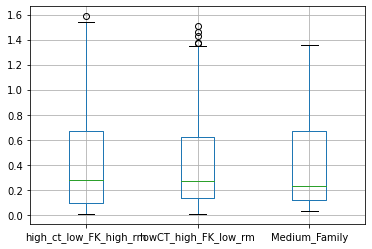

In [ ]:
rel_df.boxplot()
plt.title('Box plot of differences ')

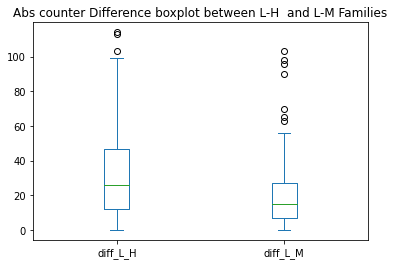

In [ ]:
df[['diff_L_H','diff_L_M' ]].plot.box()
plt.title('Abs counter Difference boxplot between L-H  and L-M Families')
plt.show()

In [ ]:
#cOMPARE CHOICES BETWEEN DIFFERENT FAMILIES (LOW CT, LOW FAKE)

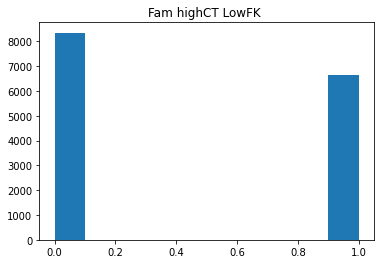

In [ ]:
plt.hist(l_t_f)
plt.title('Fam highCT LowFK ')
plt.show()

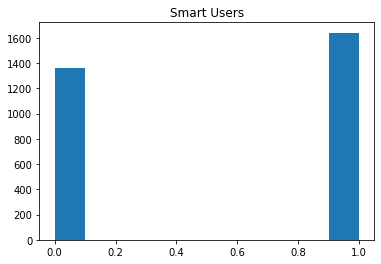

In [ ]:
plt.hist(l_t_f)
plt.title('Smart Users')
plt.show()

In [ ]:
import math

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

# Save All aswners

In [15]:
class something():
    color = 'red'
    
    def load_data():
        df = pd.read_excel('DEF_images_data.xlsx')
        return df

In [16]:
a = something()
b = something.load_data()

FileNotFoundError: [Errno 2] No such file or directory: 'data//DEF_images_data.xlsx'

In [ ]:
#torch.save(ALL_ANSWER, '/content/drive/MyDrive/Simulazione Marco Siino/test_ALL_ANSWER.pt')
torch.save(ALL_ANSWER, '/content/drive/MyDrive/Simulazione Marco Siino/3kUser_No_embedding.pt')

In [ ]:
#loadallansw = torch.load('/content/drive/MyDrive/Simulazione Marco Siino/test_ALL_ANSWER.pt')
#loadallansw = torch.load('/content/drive/MyDrive/Simulazione Marco Siino/ANSW_VIR_FAKE_TOPIC.pt')
loadallansw = torch.load('/content/drive/MyDrive/Simulazione Marco Siino/10kUser_No_embedding.pt')
loadallansw = torch.load('/content/drive/MyDrive/Simulazione Marco Siino/3kUser_No_embedding.pt')

In [74]:
loadallansw = ALL_ANSWER

In [83]:
user_example = dict(zip(range(30), loadallansw[8]))
user_example

{0: ['1bzo7r6lodq51.png', array([0.91161806]), array([0.81449742])],
 1: ['trump_Vera_CA_MB.jpg', array([0.85048471]), array([0.80390456])],
 2: ['citiy sub.PNG', array([0.9870725]), array([0.24411028])],
 3: ['DT_moP8W4AAq4Ig.jpg', array([0.89761481]), array([0.05313051])],
 4: ['Funny-Bill-Clinton-With-Long-Nose.jpg',
  array([0.80555627]),
  array([0.85849278])],
 5: ['strange27.PNG', array([0.94151984]), array([0.02198223])],
 6: ['fotomontaggio-berlusconi-papa-ricco-1280x720.jpg',
  array([0.83903981]),
  array([0.87045062])],
 7: ['o656210.jpg', array([0.97026688]), array([0.25654732])],
 8: ['Catturaseawave.PNG', array([0.96486031]), array([0.08737187])],
 9: ['putin fakeg8.jpg', array([0.85252353]), array([0.10257953])],
 10: ['mithc2.PNG', array([0.85123874]), array([0.19234099])],
 11: ['download2.jpg', array([0.86074959]), array([0.91995325])],
 12: ['Godzilla_statueofliberty_trailer.jpg',
  array([0.73115123]),
  array([0.9403669])],
 13: ['187780535_465854274480265_8714607

In [ ]:
#example from user 42
user_example = dict(zip(range(30), loadallansw[42]))
user_example

{0: ['giant_ship.jpg', array([0.01058348]), 0.5],
 1: ['car.jpg', array([0.45653026]), 0.5],
 2: ['75214698_163803448162335_423691969536250799_n.jpg',
  array([0.63756536]),
  0.5],
 3: ['moon.jpg', array([0.22146348]), 0.5],
 4: ['225029973_3070110136544933_7909752207912876690_n.jpg',
  array([0.80028417]),
  0.5],
 5: ['week20-21-01.jpg-nggid0524324-ngg0dyn-900x600x100-00f0w010c010r110f110r010t010.jpg',
  array([0.43866876]),
  0.5],
 6: ['hurricane.jpg', array([0.60517722]), 0.5],
 7: ['giant_moon.jpg', array([0.41418462]), 0.5],
 8: ['merlin_190627818_41f0a3e1-8f27-41b2-a040-26d54c996e9b-superJumbo.jpg',
  array([0.68699386]),
  0.5],
 9: ['planet plus moon fake.jpg', array([0.65784797]), 0.5],
 10: ['225250510_620087758972367_9168951633142805579_n.jpg',
  array([0.49465962]),
  0.5],
 11: ['baby-trump1.jpg', array([0.68042094]), 0.5],
 12: ['veenzia_F_LC_HM.jpg', array([0.69147894]), 0.5],
 13: ['london-has-fa.jpg', array([0.66600258]), array([0.35854583])],
 14: ['tsunami faro.PN

## Explore Anwer

[('tsunami faro.PNG', 9), ('Cattura_tsunami.PNG', 8), ('citiy sub.PNG', 8), ('Catturaseawave.PNG', 8), ('photo-contest-week-26-2021-przemek-rodzik-lightning-strike.jpg', 8)]


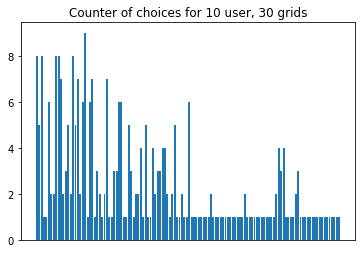

In [81]:
#Inspect the frequenc of choices. 
limg = []
for i in loadallansw:
  #print(i)
  imgs = [j[0] for j in loadallansw[i]]
  limg.append(imgs)
flat_list = [item for sublist in limg for item in sublist]

count = Counter(flat_list)
print(count.most_common(5))

plt.bar(count.keys(), count.values())
plt.xticks(rotation='vertical')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('Counter of choices for 10 user, 30 grids')

plt.show()

Text(0.5, 1.0, 'Histogram of probability that an image is credible coloured by credibility label')

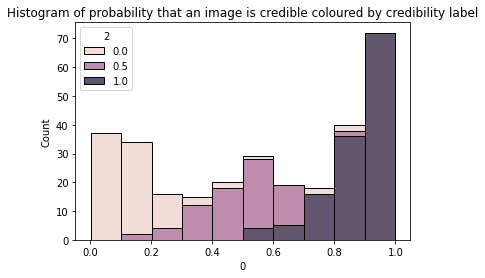

In [79]:
#Inspect the probabiity that an image is true 
limg = []
l_names = []
l_tf = []
for i in loadallansw:
  #print(i)
  names = [j[0] for j in loadallansw[i]]
  imgs = [float(j[1]) for j in loadallansw[i]]
  t_f = df_imgs.loc[names]['cred'].values
  limg.append(imgs)
  l_names.append(names)
  l_tf.append(t_f)
flat_list = [item for sublist in limg for item in sublist]
flat_list_names = [item for sublist in l_names for item in sublist]
flat_list_tf = [item for sublist in l_tf for item in sublist]

tt = pd.DataFrame(data=[flat_list,flat_list_names,flat_list_tf]).T

sns.histplot(data=tt, x=0, hue=2, multiple="stack").set_title('Histogram of probability that an image is credible coloured by credibility label')

Text(0.5, 1.0, 'Histogram of probability that an image is manipulated coloured by manipulation label')

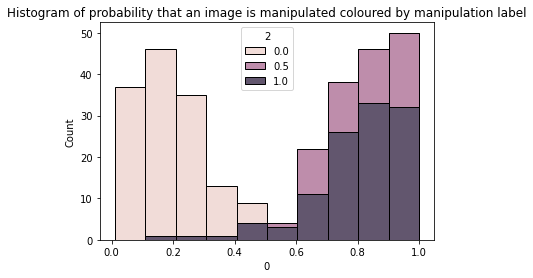

In [80]:
#Inspect the probabiity that an image is maniulated
limg = []
l_names = []
l_manip = []
for i in loadallansw:
  #print(i)
  names = [j[0] for j in loadallansw[i]]
  imgs = [float(j[2]) for j in loadallansw[i]]
  manip = df_imgs.loc[names]['manip'].values
  limg.append(imgs)
  l_names.append(names)
  l_manip.append(manip)
flat_list = [item for sublist in limg for item in sublist]
flat_list_names = [item for sublist in l_names for item in sublist]
flat_list_manip = [item for sublist in l_manip for item in sublist]


tt = pd.DataFrame(data=[flat_list,flat_list_names,flat_list_manip]).T


sns.histplot(data=tt, x=0, hue=2, multiple="stack").set_title('Histogram of probability that an image is manipulated coloured by manipulation label')

In [82]:
def plot_choices(loadallansw, df_imgs, var = 'cred'):
    limg    = []
    l_names = []
    l_manip = []
    for i in loadallansw:
        names  = [j[0] for j in loadallansw[i]]
        if var =='manip':
            imgs = [float(j[2]) for j in loadallansw[i]]
        elif var =='cred':
            imgs = [float(j[1]) for j in loadallansw[i]]
        manip = df_imgs.loc[names][var].values
        limg.append(imgs)
        l_names.append(names)
        l_manip.append(manip)
    flat_list = [item for sublist in limg for item in sublist]
    flat_list_names = [item for sublist in l_names for item in sublist]
    flat_list_manip = [item for sublist in l_manip for item in sublist]

    tt = pd.DataFrame(data=[flat_list,flat_list_names,flat_list_manip]).T
    title = 'Histogram of probability that an image is manipulated coloured by label' + var
    sns.histplot(data=tt, x=0, hue=2, multiple="stack").set_title(title)
    return

# TensorFlow Dataset

In [ ]:
start = time.time()

num_user, num_grid , num_imgs, num_features_x =  500, 30, 8, 7
#num_features_y = 7  #topic pref + critthink    + pref_vir + pref_fake
num_features_y = 12  #topic pref + critthink    + pref_vir + pref_fake + kt_topic

x = np.zeros(shape=[num_user, num_grid , num_imgs, num_features_x])
#y = np.zeros(shape=[num_user,num_grid, 1, num_features_y])
y = np.zeros(shape=[num_user, num_features_y])
y_grid = np.zeros(shape=[num_user, num_grid , 2])

for user in range(num_user):
  user_crit_think = dict_user[user]['crit_think']
  TOPIC_PREF      = dict_user[user]['topic']
  VIR_PREF        = dict_user[user]['virality']
  FAKE_PREF       = dict_user[user]['fake']
  KT              = dict_user[user]['kt']
  RM              = dict_user[user]['rm']  
  y_answers = np.concatenate(([user_crit_think], [VIR_PREF], [FAKE_PREF],TOPIC_PREF, KT, [RM] ))
  y[user, : ] = y_answers
  for grid in range(num_grid):
    grids_imgs = [i.split('/')[1] for i in grids[grid]]
    imgs_feat = df_imgs.loc[grids_imgs].drop(['folder', 'url'], axis = 1).values
    for image in range(num_imgs):
      choosen, prob_vera, prob_manip  = loadallansw[user][grid][0], loadallansw[user][grid][1], loadallansw[user][grid][2]
      #print(choosen, prob_vera, prob_manip)
      choosen_arr = np.array([1 if i== choosen else 0 for i in grids_imgs]).reshape(8,1)
      
      #print(imgs_feat)
      #embedding = np.array([imgs_emb[i].numpy().reshape(1000) for i in grids_imgs])
      #imgs  = np.append(imgs_feat, embedding, axis=1)
      #print(imgs.shape)
      imgs  = np.append(imgs_feat, choosen_arr, axis=1)   
      #print(imgs.shape)
      #print()
      #y_answers = np.concatenate(([user_crit_think],[prob_vera],[prob_manip],TOPIC_PREF, [VIR_PREF] ))
      #y_answers = np.concatenate(([user_crit_think], [VIR_PREF], [FAKE_PREF],TOPIC_PREF ))
      x[user, grid, : , :]   = imgs
      y_grid[user, grid, : ] =  prob_vera, prob_manip
      #y[user, : , :] = y_answers

print('tot time',time.time()- start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


tot time 22.337538242340088


In [ ]:
print(x.shape)
print(y.shape)
print(y_grid.shape)

(500, 30, 8, 7)
(500, 12)
(500, 30, 2)


In [ ]:
y[0, : ]

array([ 0.19235226,  0.37056617,  0.70497567,  0.13424948, -0.49690051,
       -0.99871624,  0.96643099,  0.14855197,  0.15514435,  0.04047341,
        0.15663121,  0.19344669])

In [ ]:
imgs_feat

array([[1.  , 1.  , 0.  , 0.  , 2.63, 0.  ],
       [0.  , 1.  , 1.  , 1.  , 3.93, 1.  ],
       [2.  , 1.  , 0.  , 1.  , 4.99, 1.  ],
       [1.  , 0.  , 1.  , 0.  , 3.7 , 0.  ],
       [3.  , 1.  , 1.  , 0.  , 7.03, 1.  ],
       [3.  , 0.  , 0.  , 1.  , 3.74, 0.  ],
       [2.  , 0.  , 0.5 , 0.  , 2.95, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 3.73, 0.  ]])

In [ ]:
# start = time.time()

# num_user, num_grid , num_imgs, num_features_x =  100, 30, 8, 1007
# num_features_y =  6 #critthink +  prob_vera   + prob_manip
# x = np.zeros(shape=[num_user, num_grid , num_imgs, num_features_x])
# y = np.zeros(shape=[num_user, num_features_y ])

# for user in range(num_user):
#   user_crit_think = dict_user[user]['crit_think']
#   TOPIC_PREF      = dict_user[user]['topic']
#   VIR_PREF        = dict_user[user]['virality']  
#   for grid in range(num_grid):
#     grids_imgs = [i.split('/')[1] for i in grids[grid]]

#     for image in range(num_imgs):
#       choosen, prob_vera, prob_manip  = loadallansw[user][grid][0], loadallansw[user][grid][1], loadallansw[user][grid][2]
#       #print(choosen, prob_vera, prob_manip)
#       choosen_arr = np.array([1 if i== choosen else 0 for i in grids_imgs]).reshape(8,1)

#       imgs_feat = df_imgs.loc[grids_imgs].drop(['folder', 'url'], axis = 1).values
#       #print(imgs_feat)
#       embedding = np.array([imgs_emb[i].numpy().reshape(1000) for i in grids_imgs])
#       imgs  = np.append(imgs_feat, embedding, axis=1)
#       #print(imgs.shape)
#       imgs  = np.append(imgs, choosen_arr, axis=1)   
#       #print(imgs.shape)
#       #print()
#       y_answers = np.concatenate(([user_crit_think],TOPIC_PREF, [VIR_PREF] ))
#       x[user, grid, : , :] = imgs
#       #y[user, grid, : , :] = user_crit_think , prob_vera, prob_manip
#       y[user , :] = y_answers

# print('tot time',time.time()- start)

tot time 26.632232189178467


In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/Multioutput_Dataset')

In [ ]:
for i in train_dataset:
  print(type(i), len(i))
  print(i[0].shape,i[1].shape,i[2].shape)
  break  

<class 'tuple'> 3
(30, 8, 7) (7,) (30, 2)


In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/Multioutput_Dataset')

# train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/LW_CriTh_HG_FAKE_Dataset')

# train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/HG_CriTh_LW_FAKE_Dataset')

# train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/3k_Users_11_Features')

# train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/3k_Users_12_Features')

# train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/500_gullible_users')

# train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
# tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/500_SMART_users')

train_dataset = tf.data.Dataset.from_tensor_slices((x, y, y_grid))
tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/500_Mixed_Users')

## Use numpy

In [ ]:
np.save('/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/x_updated.npy', x)
np.save('/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/y_updated_VIR_FAKE.npy', y)

In [ ]:
#xload = np.load('/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/x_prova.npy')
#yload = np.load('/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/y_prova.npy')


xload = np.load('/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/x_updated.npy')
yload = np.load('/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/y_updated_VIR_FAKE.npy')

In [ ]:
#import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((xload, yload))

## Use TensorFlow

In [ ]:
tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/UPDATED_tensorflow_dataset')

In [ ]:
#PATH_DATASET = '/content/drive/MyDrive/tensorflow_dataset'
PATH_DATASET = '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/UPDATED_tensorflow_dataset'

ds = tf.data.experimental.load(PATH_DATASET)

#print original dataset shapes
# for el in ds:
#   print(el[0].shape)
#   print(el[1].shape)

lxtr = []
lytr = []

lxte = []
lyte = []

for idx, el in enumerate(ds):
 if idx < 80:
  tempx = el[0].numpy().flatten().reshape(241680)
  tempy = el[1].numpy().flatten()
  lxtr.append(tempx)
  lytr.append(tempy)
 else: 
  tempx = el[0].numpy().flatten().reshape(241680)
  tempy = el[1].numpy().flatten()
  lxte.append(tempx)
  lyte.append(tempy)

#lx = np.array(lx)
#ly = np.array(ly)
#print(len(lx), '\nlx.shape',lx.shape, '\nly.shape',ly.shape)
#print(len(lx), lx[0].shape, ly[0].shape)

In [ ]:
new_dataset = tf.data.experimental.load('/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/tensorflow_dataset')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Simulazione Marco Siino/location_all_images.csv', index_col=0, dtype={'0':str})

In [ ]:
df.head()

,0
Black_lion.jpg,/content/drive/MyDrive/Dataset_Images_Francesc...
college.jpg,/content/drive/MyDrive/Dataset_Images_Francesc...
iceberg.jpg,/content/drive/MyDrive/Dataset_Images_Francesc...
lanterns.jpg,/content/drive/MyDrive/Dataset_Images_Francesc...
Paris_shirt.jpg,/content/drive/MyDrive/Dataset_Images_Francesc...


In [ ]:
df.loc['Black_lion.jpg'][0]

'/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/images/commons/commons_F_HC_HM/Black_lion.jpg'

# generate 10k users and simulate choices and write answers

In [ ]:
num_user = 1000
dict_user = create_users(num_user, 4)

In [ ]:
start = time.time()
ALL_ANSWER = {}
for user in range(len([*dict_user])): 
  ALL_ANSWER[user] = []
  user_pref =  dict_user[user]
  user_personalized_grids = grids
  for grid in range(30):
    img_names = user_personalized_grids[grid]
    img_names = [i.split('/')[-1] for i in img_names]
    IMG_FEAT_DICT = df_imgs.loc[img_names].T.to_dict()
    #print('img_names', img_names)
    grid_scores , grid_asnwer = V2_generate_Rank(img_names , IMG_FEAT_DICT, imgs_emb,dict_user,user,lower=0, upper=1, mysigma=0.2, plot=False)
    choosen_img = max(grid_scores, key=grid_scores.get)
    #print('user, choosen_img\n', user, choosen_img)
    answer_tru, answer_manip = grid_asnwer[choosen_img]
    answer_tru = answer_tru[0]  #it was an array now is a float
    ALL_ANSWER[user].append([choosen_img, answer_tru, answer_manip])
  print('grid ', grid)
print('tot time',time.time()- start)

grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
grid  29
g

In [ ]:
loadallansw = ALL_ANSWER

'Cat34535tura.PNG'

In [ ]:
start = time.time()


loadallansw = ALL_ANSWER

num_user, num_grid , num_imgs, num_features_x =  1000, 30, 8, 7
num_features_y = 7 + 2 *num_grid#topic pref + critthink    + pref_vir + pref_fake

x = np.zeros(shape=[num_user, num_grid , num_imgs, num_features_x])
y = np.zeros(shape=[num_user, num_features_y])


feat_grids_dict = {}
for grid in range(num_grid):
  grids_imgs = [i.split('/')[1] for i in grids[grid]]
  imgs_feat = df_imgs.loc[grids_imgs].drop(['folder', 'url'], axis = 1).values
  feat_grids_dict[grid] = imgs_feat

for user in range(num_user):
  user_crit_think = dict_user[user]['crit_think']
  TOPIC_PREF      = dict_user[user]['topic']
  VIR_PREF        = dict_user[user]['virality']
  FAKE_PREF        = dict_user[user]['fake']  
  y_answers = np.concatenate(([user_crit_think], [VIR_PREF], [FAKE_PREF],TOPIC_PREF ))
  y[user, : ] = y_answers
  for grid in range(num_grid):
    imgs_feat = feat_grids_dict[grid]
    grids_imgs = [i.split('/')[1] for i in grids[grid]] 
    for image in range(num_imgs):
      choosen, prob_vera, prob_manip  = loadallansw[user][grid][0], loadallansw[user][grid][1], loadallansw[user][grid][2]
      #print(choosen, prob_vera, prob_manip)
      choosen_arr = np.array([1 if i == choosen else 0 for i in grids_imgs]).reshape(8,1)
      
      #print(choosen_arr)
      
      #embedding = np.array([imgs_emb[i].numpy().reshape(1000) for i in grids_imgs])
      #imgs  = np.append(imgs_feat, embedding, axis=1)
      #print(imgs.shape)
      imgs  = np.append(imgs_feat, choosen_arr, axis=1)   
      #print(imgs.shape)
      #print()
      #y_answers = np.concatenate(([user_crit_think],[prob_vera],[prob_manip],TOPIC_PREF, [VIR_PREF] ))
      #y_answers = np.concatenate(([user_crit_think], [VIR_PREF], [FAKE_PREF],TOPIC_PREF ))
      x[user, grid, : , :] = imgs
      y[user, grid, : , :] = user_crit_think , prob_vera, prob_manip
      #y[user, : , :] = y_answers

print('tot time',time.time()- start)

tot time 3.4107329845428467


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
tf.data.experimental.save(train_dataset, '/content/drive/MyDrive/Dataset_Images_Francesco_Politics_Space/1k_User')

In [ ]:
start = time.time()


loadallansw = ALL_ANSWER

num_user, num_grid , num_imgs, num_features_x =  1000, 30, 8, 7
num_features_y = 7 + 2 *num_grid#topic pref + critthink    + pref_vir + pref_fake

x = np.zeros(shape=[num_user, num_grid , num_imgs, num_features_x])
y = np.zeros(shape=[num_user, num_features_y])


feat_grids_dict = {}
for grid in range(num_grid):
  grids_imgs = [i.split('/')[1] for i in grids[grid]]
  imgs_feat = df_imgs.loc[grids_imgs].drop(['folder', 'url'], axis = 1).values
  feat_grids_dict[grid] = imgs_feat

for user in range(num_user):
  user_crit_think = dict_user[user]['crit_think']
  TOPIC_PREF      = dict_user[user]['topic']
  VIR_PREF        = dict_user[user]['virality']
  FAKE_PREF        = dict_user[user]['fake']  
  y_answers = np.concatenate(([user_crit_think], [VIR_PREF], [FAKE_PREF],TOPIC_PREF ))
  y[user, : ] = y_answers
  for grid in range(num_grid):
    imgs_feat = feat_grids_dict[grid]
    grids_imgs = [i.split('/')[1] for i in grids[grid]] 
    for image in range(num_imgs):
      choosen, prob_vera, prob_manip  = loadallansw[user][grid][0], loadallansw[user][grid][1], loadallansw[user][grid][2]
      #print(choosen, prob_vera, prob_manip)
      choosen_arr = np.array([1 if i == choosen else 0 for i in grids_imgs]).reshape(8,1)
      
      #print(choosen_arr)
      
      #embedding = np.array([imgs_emb[i].numpy().reshape(1000) for i in grids_imgs])
      #imgs  = np.append(imgs_feat, embedding, axis=1)
      #print(imgs.shape)
      imgs  = np.append(imgs_feat, choosen_arr, axis=1)   
      #print(imgs.shape)
      #print()
      #y_answers = np.concatenate(([user_crit_think],[prob_vera],[prob_manip],TOPIC_PREF, [VIR_PREF] ))
      #y_answers = np.concatenate(([user_crit_think], [VIR_PREF], [FAKE_PREF],TOPIC_PREF ))
      x[user, grid, : , :] = imgs
      y[user, grid, : , :] = user_crit_think , prob_vera, prob_manip
      #y[user, : , :] = y_answers

print('tot time',time.time()- start)

# Class simulation